# Working with Unlabeled Data – Clustering Analysis

In the previous chapters, we used supervised learning techniques to build machine learning models, using data where the answer was already known—the class labels were already available in our training data. In this chapter, we will switch gears and explore cluster analysis, a category of unsupervised learning techniques that allows us to discover hidden structures in data where we do not know the right answer upfront. The goal of clustering is to find a natural grouping in data so that items in the same cluster are more similar to each other than to those from different clusters.

## K - means clustering

Clustering (or cluster analysis) is a technique that allows us to find groups of similar objects that are more related to each other than to objects in other groups.

Grouping of documents, music, and movies by different topics, or finding customers that share similar interests based on common purchase behaviors as a basis for recommendation engines

### prototype-based clustering

each cluster is represented by a prototype, which is usually either:
- the centroid (average) of similar points with continuous features
- or the medoid (the most representative or the point that minimizes
the distance to all other points that belong to a particular cluster) in the case of categorical features

While k-means is very good at identifying clusters with a spherical shape

one of the drawbacks of this clustering algorithm is that we have to specify the number of clusters - k

choice for k can result in poor clustering performance

k-means clustering can be applied to data in higher dimensions

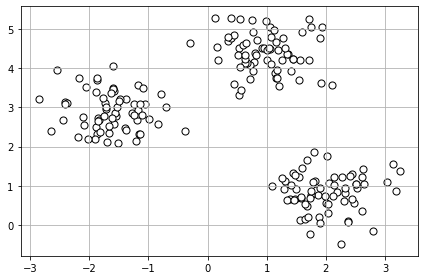

In [19]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200,
                 n_features=2,
                 centers=3,
                 cluster_std=0.5,
                 shuffle=True,
                 random_state=0)

import matplotlib.pyplot as plt

plt.scatter(X[:, 0],
           X[:, 1],
           c='white',
           marker='o',
           edgecolor='black',
           s=50)

plt.grid()
plt.tight_layout()
plt.show()

Goal is to group the examples based on their feature similarities, which can be achieved using the k-means algorithm, as summarized by the following four steps:

- Randomly pick k centroids from the examples as initial cluster centers.
- Assign each example to the nearest centroid, 𝜇(𝑗), 𝑗 ∈ {1, ... , 𝑘}
- Move the centroids to the center of the examples that were assigned to it.
- Repeat steps 2 and 3 until the cluster assignments do not change or a user- defined tolerance or maximum number of iterations is reached.

In [20]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,   # number of desired cluster
           init='random',
           n_init=10,       # run the k-means clustering algorithms 10 times independently, with different random centroids to choose the final model as the one with the lowest SSE
           max_iter=300,    # maximum number of iterations for each single run
           tol=1e-04,       # controls the tolerance with regard to the changes in the within-cluster SSE to declare convergence
           random_state=0)

y_km = km.fit_predict(X)

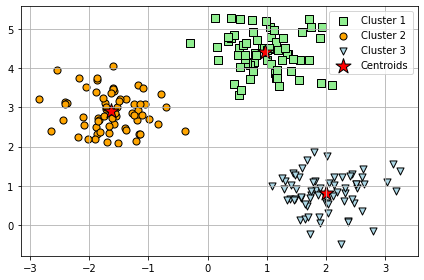

In [22]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')

plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')

# centroids
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.savefig('kmeans.png', dpi=300)
plt.show()

# k-means++

So far, we have discussed the classic k-means algorithm, which uses a random seed to place the initial centroids, which can sometimes result in bad clusterings or slow convergence if the initial centroids are chosen poorly. One way to address this issue is to run the k-means algorithm multiple times on a dataset and choose the best performing model in terms of the SSE

Another strategy is to place the initial centroids far away from each other via the k-means++ algorithm, which leads to better and more consistent results than the classic k-means

In [23]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 94.00


Based on the within-cluster SSE, we can use a graphical tool, the so-called elbow method, to estimate the optimal number of clusters, k, for a given task. We can say that if k increases, the distortion will decrease. This is because the examples will be closer to the centroids they are assigned to. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly, which will become clearer if we plot the distortion for different values of k

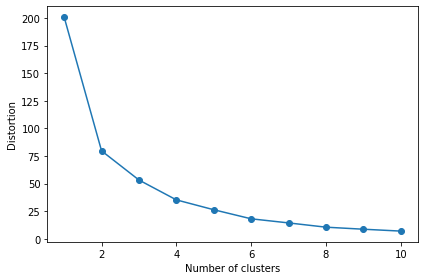

In [57]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.savefig('numClusters.png', dpi=300)
plt.show()

As you can see in the following plot, the elbow is located at k = 3, so this is evidence that k = 3 is indeed a good choice for this dataset:

## Quantifying the quality of clustering via silhouette plots

Silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the examples in the clusters are

The silhouette coefficient is available as silhouette_samples from scikit-learn's metric module, and optionally, the silhouette_scores function can be imported for convenience. The silhouette_scores function calculates the average silhouette coefficient across all examples, which is equivalent to numpy.mean(silhouette_ samples(...)). By executing the following code, we will now create a plot of the silhouette coefficients for a k-means clustering with k = 3:

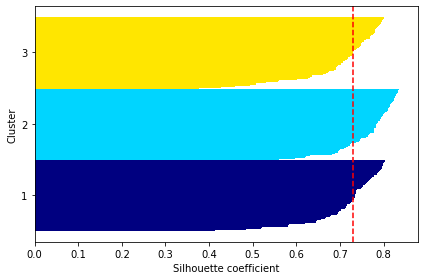

In [27]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.savefig('silhouette.png', dpi=300)
plt.show()

Through a visual inspection of the silhouette plot, we can quickly scrutinize the sizes of the different clusters and identify clusters that contain outliers

silhouette coefficients are not even close to 0, which is, in this case, an indicator of a good clustering

to summarize the goodness of our clustering, we added the average silhouette coefficient to the plot (dotted line)

#### comparision to bad clustering - k-means with only 2 centroids

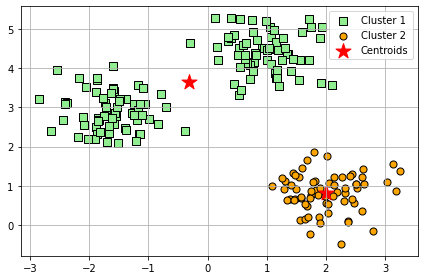

In [29]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            edgecolor='black',
            marker='s',
            label='Cluster 1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            edgecolor='black',
            marker='o',
            label='Cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='Centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('twocentroids.png', dpi=300)
plt.show()

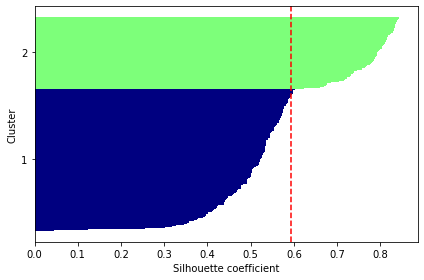

In [30]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_06.png', dpi=300)
plt.show()

silhouettes now have visibly different lengths and widths, which is evidence of a relatively bad or at least suboptimal clustering

# Organizing clusters as a hierarchical tree

Advantage of the hierarchical clustering algorithm is that it allows us to plot dendrograms (visualizations of a binary hierarchical clustering), which can help with the interpretation of the results by creating meaningful taxonomies. Another advantage of this hierarchical approach is that we do not need to specify the number of clusters upfront.

The two main approaches to hierarchical clustering are agglomerative and divisive hierarchical clustering.

DIVISIVE clustering

Start with one cluster that encompasses the complete dataset, and iteratively split the cluster into smaller clusters until each cluster only contains one example. 

AGGLOMERATIVE clustering

Takes the opposite approach. Start with each example as an individual cluster and merge the closest pairs of clusters until only one cluster remains.

- single linkage - compute the distances between the most similar members for each pair of clusters and merge the two clusters for which the distance between the most similar members is the smallest
- complete linkage - similar to single linkage but, instead of comparing the most similar members in each pair of clusters, we compare the most dissimilar members to perform the merge

In [31]:
import pandas as pd
import numpy as np

np.random.seed(123)
variables=['X', 'Y', 'Z']
labels=['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [32]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                       columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Using the preceding code, we calculated the Euclidean distance between each pair of input examples in our dataset based on the features X, Y, and Z

In [33]:
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1d condensed distance matrix
    or a 2d array of observation vectors.
    
    If y is a 1d condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the n

In [36]:
# 1. incorrect approach: Squareform distance matrix

row_clusters = linkage(row_dist, method='complete', metric='euclidean')

pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

/Users/timco/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [37]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')

pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [38]:
# 3. correct approach: Input matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')

pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


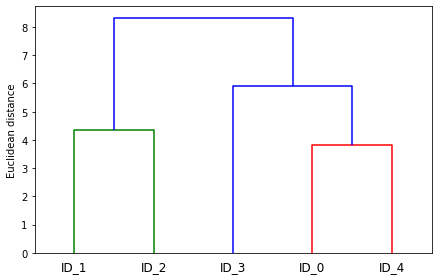

In [41]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

examples ID_0 and ID_4, followed by ID_1 and ID_2, are the most similar ones based on the Euclidean distance metric

### Attaching dendrograms to a heat map

In practical applications, hierarchical clustering dendrograms are often used in combination with a heat map, which allows us to represent the individual values in the data array or matrix containing our training examples with a color code.

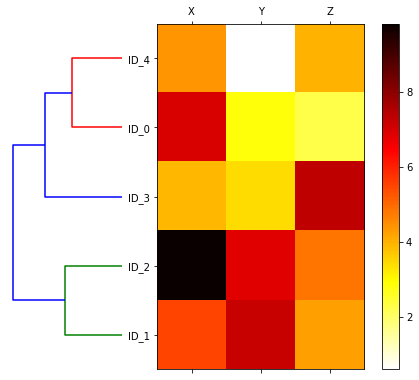

In [43]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
    i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.savefig('heatmap.png', dpi=300)
plt.show()

## Applying agglomerative clustering via scikit- learn

In [45]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,
                            affinity='euclidean',
                            linkage='complete')

labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)
# 0 1 2 3 4 - so it is the same, ID_0 and ID_4 = label 1, ID_3 = label2, ID_1 and ID_2 = label 0

Cluster labels: [1 0 0 2 1]


In [46]:
ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)

print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


## Locating regions of high density via DBSCAN

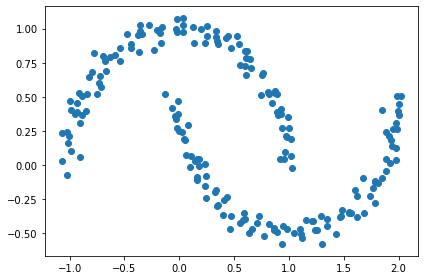

In [48]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
#plt.savefig('images/11_14.png', dpi=300)
plt.show()

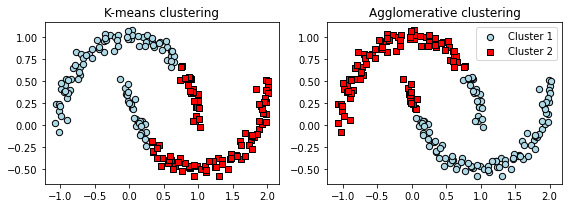

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))



km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)

ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1], edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')

ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1], edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')

ax1.set_title('K-means clustering')




ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)

ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue', 
            edgecolor='black', marker='o', s=40, label='Cluster 1')

ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red', 
            edgecolor='black', marker='s', s=40, label='Cluster 2')

ax2.set_title('Agglomerative clustering')



plt.legend()
plt.tight_layout()
plt.savefig('kmeans_agg.png', dpi=300)
plt.show()

### DBSCAN - density based clustering

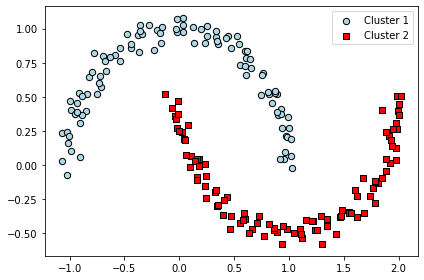

In [56]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)

plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 2')

plt.legend()
plt.tight_layout()
plt.savefig('DBSCAN.png', dpi=300)
plt.show()

It is important to emphasize that a successful clustering does not only depend on the algorithm and its hyperparameters; rather, the choice of an appropriate distance metric and the use of domain knowledge that can help to guide the experimental setup can be even more important

# Summary


- K-means - clusters examples into spherical shapes based on a specified number of cluster centroids. Since clustering is an unsupervised method, we do not enjoy the luxury of ground truth labels to evaluate the performance of a model. Thus, we used intrinsic performance metrics, such as the elbow method or silhouette analysis, as an attempt to quantify the quality of clustering.
- We then looked at a different approach to clustering: agglomerative hierarchical clustering. Hierarchical clustering does not require specifying the number of clusters upfront, and the result can be visualized in a dendrogram representation, which can help with the interpretation of the results. 
- The last clustering algorithm that we covered in this chapter was DBSCAN, an algorithm that groups points based on local densities and is capable of handling outliers and identifying non-globular shapes.